<a href="https://colab.research.google.com/github/armandordorica/Twitter_Sentiment_Analysis/blob/master/RNN_time_series_predictions_weather_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/content


In [2]:
!git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials.git

Cloning into 'TensorFlow-Tutorials'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 506 (delta 1), reused 14 (delta 1), pack-reused 480
Receiving objects: 100% (506/506), 76.90 MiB | 10.80 MiB/s, done.
Resolving deltas: 100% (228/228), done.


In [3]:
ls

sample_data/  TensorFlow-Tutorials/


In [4]:
cd TensorFlow-Tutorials/

/content/TensorFlow-Tutorials


In [5]:
ls

01_Simple_Linear_Model.ipynb           21_Machine_Translation.ipynb
02_Convolutional_Neural_Network.ipynb  22_Image_Captioning.ipynb
03B_Layers_API.ipynb                   23_Time-Series-Prediction.ipynb
03C_Keras_API.ipynb                    cache.py
03_PrettyTensor.ipynb                  cifar10.py
04_Save_Restore.ipynb                  coco.py
05_Ensemble_Learning.ipynb             convert.py*
06_CIFAR-10.ipynb                      dataset.py
07_Inception_Model.ipynb               download.py
08_Transfer_Learning.ipynb             europarl.py
09_Video_Data.ipynb                    forks.md
10_Fine-Tuning.ipynb                   images/
11_Adversarial_Examples.ipynb          imdb.py
12_Adversarial_Noise_MNIST.ipynb       inception5h.py
13B_Visual_Analysis_MNIST.ipynb        inception.py
13_Visual_Analysis.ipynb               knifey.py
14_DeepDream.ipynb                     LICENSE
15_Style_Transfer.ipynb                mnist.py
16_Reinforcement_Learning.ipynb        README.md
17_Esti

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [0]:
import weather


In [9]:
weather.maybe_download_and_extract()


- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [10]:

cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

In [0]:

# %%time
df = weather.load_resampled_data()

In [12]:
df.head()


Aalborg               ...   Roskilde            
                         Temp     Pressure  ...  WindSpeed     WindDir
DateTime                                    ...                       
1980-03-01 11:00:00  5.000000  1007.766667  ...  11.466667  280.000000
1980-03-01 12:00:00  5.000000  1008.000000  ...  12.466667  280.000000
1980-03-01 13:00:00  5.000000  1008.066667  ...  13.133333  278.333333
1980-03-01 14:00:00  4.333333  1008.133333  ...  12.300000  270.000000
1980-03-01 15:00:00  4.000000  1008.200000  ...  12.300000  270.000000

[5 rows x 20 columns]

Generate this data by creating a predictive model that generates the missing data from all the other input signals. Then you could add these generated values back into the data-set to fill the gaps.

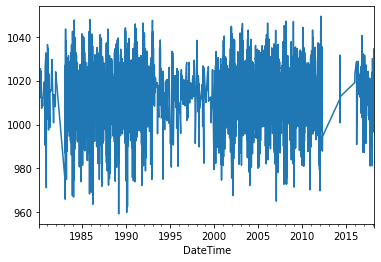

In [13]:
df['Esbjerg']['Pressure'].plot();


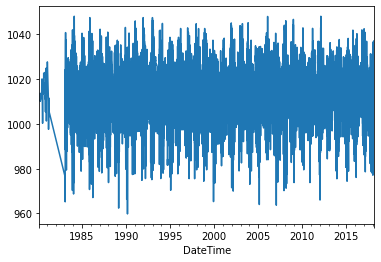

In [14]:
df['Roskilde']['Pressure'].plot();


Before removing these two signals, there are 20 input-signals in the data-set.



In [15]:
df.values.shape


(333109, 20)

## Removing signals with missing data

In [0]:
df.drop(('Esbjerg', 'Pressure'), axis=1, inplace=True)
df.drop(('Roskilde', 'Pressure'), axis=1, inplace=True)

Now we're only left with 18 input signals in the data

In [17]:
df.values.shape


(333109, 18)

We can verify that those two columns (Pressure for Esbjerg and Roskilde have been removed)

In [19]:
df.head(1)


Aalborg                         ... Roskilde                   
                       Temp     Pressure WindSpeed  ...     Temp  WindSpeed WindDir
DateTime                                            ...                            
1980-03-01 11:00:00     5.0  1007.766667      10.2  ...      5.0  11.466667   280.0

[1 rows x 18 columns]

The spikes there are noise. 

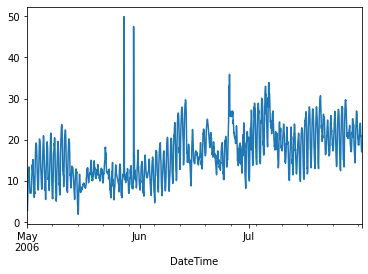

In [20]:
df['Odense']['Temp']['2006-05':'2006-07'].plot();

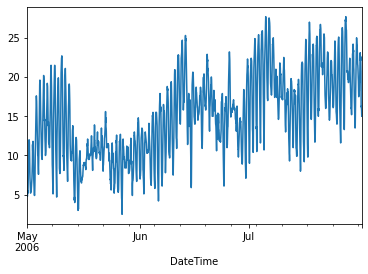

In [21]:
df['Aarhus']['Temp']['2006-05':'2006-07'].plot();


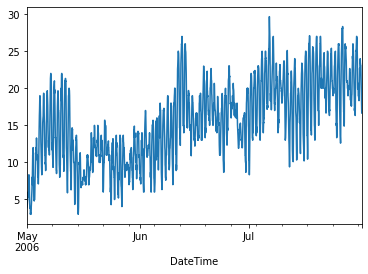

In [22]:
df['Roskilde']['Temp']['2006-05':'2006-07'].plot();


In [0]:
df['Various', 'Day'] = df.index.dayofyear
df['Various', 'Hour'] = df.index.hour

### Creating a model that predicts future weather data for a city

In [0]:
target_city = 'Odense'


In [0]:
target_names = ['Temp', 'WindSpeed', 'Pressure']



The following is the number of time-steps that we will shift the target-data. Our data-set is resampled to have an observation for each hour, so there are 24 observations for 24 hours.

**If we want to predict the weather 24 hours into the future, we shift the data 24 time-steps. If we want to predict the weather 7 days into the future, we shift the data 7 * 24 time-steps.**



In [0]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

Create a new data-frame with the time-shifted data.

**Note the negative time-shift!**




In [0]:
df_targets = df[target_city][target_names].shift(-shift_steps)


WARNING! You should double-check that you have shifted the data in the right direction! We want to predict the future, not the past!

The shifted data-frame is confusing because Pandas keeps the original time-stamps even though we have shifted the data. You can check the time-shift is correct by comparing the original and time-shifted data-frames.

This is the first shift_steps + 5 rows of the original data-frame:

In [28]:
df_targets.head(5)


,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,2.000000,6.828571,1005.833333
1980-03-01 12:00:00,2.000000,8.200000,1005.200000
1980-03-01 13:00:00,0.166667,9.216667,1004.766667
1980-03-01 14:00:00,1.000000,11.885714,1004.333333
1980-03-01 15:00:00,1.000000,12.400000,1003.900000


**Note that the last five row items are the same as the df above except for the shifted datetime**

In [29]:
df[target_city][target_names].head(shift_steps + 5)


,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,6.142857,12.585714,1011.066667
1980-03-01 12:00:00,7.000000,11.300000,1011.200000
1980-03-01 13:00:00,7.000000,12.118182,1011.300000
1980-03-01 14:00:00,6.857143,12.742857,1011.400000
1980-03-01 15:00:00,6.000000,12.400000,1011.500000
1980-03-01 16:00:00,4.909091,12.618182,1011.688889
1980-03-01 17:00:00,3.953488,12.646512,1011.877778
1980-03-01 18:00:00,3.674419,11.725581,1012.066667
1980-03-01 19:00:00,3.395349,10.804651,1012.255556



The time-shifted data-frame has the same length as the original data-frame, but the last observations are NaN (not a number) because the data has been shifted backwards so we are trying to shift data that does not exist in the original data-frame.

In [30]:
df_targets.tail()


,Temp,WindSpeed,Pressure
DateTime,,,
2018-03-01 19:00:00,NaN,NaN,NaN
2018-03-01 20:00:00,NaN,NaN,NaN
2018-03-01 21:00:00,NaN,NaN,NaN
2018-03-01 22:00:00,NaN,NaN,NaN
2018-03-01 23:00:00,NaN,NaN,NaN


**NumPy Arrays**

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has NaN for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.

These are the input-signals:

In [0]:
x_data = df.values[0:-shift_steps]


In [32]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 20)


### **Output signals (target signals)**

In [0]:
y_data = df_targets.values[:-shift_steps]

In [34]:

print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 3)


### **Num of observations (data points or samples) in the data set**

In [35]:
num_data = len(x_data)
num_data

333085

In [0]:
train_split = 0.9


In [37]:

num_train = int(train_split * num_data)
num_train

299776

In [38]:

num_test = num_data - num_train
num_test

33309

In [39]:

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

333085

### **These are the output-signals for the training- and test-sets:**

In [40]:

y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

333085

**This is the number of input-signals or columns**
They are the following: 
```
MultiIndex([( 'Aalborg',      'Temp'),
            ( 'Aalborg',  'Pressure'),
            ( 'Aalborg', 'WindSpeed'),
            ( 'Aalborg',   'WindDir'),
            (  'Aarhus',      'Temp'),
            (  'Aarhus',  'Pressure'),
            (  'Aarhus', 'WindSpeed'),
            (  'Aarhus',   'WindDir'),
            ( 'Esbjerg',      'Temp'),
            ( 'Esbjerg', 'WindSpeed'),
            ( 'Esbjerg',   'WindDir'),
            (  'Odense',      'Temp'),
            (  'Odense',  'Pressure'),
            (  'Odense', 'WindSpeed'),
            (  'Odense',   'WindDir'),
            ('Roskilde',      'Temp'),
            ('Roskilde', 'WindSpeed'),
            ('Roskilde',   'WindDir'),
            ( 'Various',       'Day'),
            ( 'Various',      'Hour')],
           )
```

In [41]:
num_x_signals = x_data.shape[1]
num_x_signals

20

The target variables are 3 and they're the following: 
```
df_targets[:-shift_steps].columns
```

In [42]:
num_y_signals = y_data.shape[1]
num_y_signals

3

### Data scaling. Neural networks work best when values are between -1 and 1. Therefore we'll us MinMaxScaler from Scikit learn to rescale the values that are currently between -27 and 1050.8

**We'll rescale both `x_train` and `x_test`**

In [43]:

print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -27.0
Max: 1050.8


In [0]:
x_scaler = MinMaxScaler()


In [0]:
x_train_scaled = x_scaler.fit_transform(x_train)


In [46]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [0]:
x_test_scaled = x_scaler.transform(x_test)


**Apply rescaling to target variables as well**

In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)


Data Generator
The data-set has now been prepared as 2-dimensional numpy arrays. The training-data has almost 300k observations, consisting of 20 input-signals and 3 output-signals.

These are the array-shapes of the input and output data:

In [49]:

print(x_train_scaled.shape)
print(y_train_scaled.shape)

(299776, 20)
(299776, 3)


Instead of trying to train all the ~300k samples at once, we'll train on smaller sub-batches picked at random. 

In [0]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

The larger the batch-size, the more we can increase GPU utilization. 

In [0]:
batch_size = 256


The length of each sequence on each batch will be 8 weeks, which is 24 x 7 x 8 = 1344

In [52]:
sequence_length = 24 * 7 * 8
sequence_length

1344

**Batch size** is how many concurrent items we'll feed into the model, whereas **sequence length** is the size of the sequence that we want to learn. A good rule of thumb to select sequence length is `total_length`/`batch_size` which in this case is 1171, close to our sequence length of 1344. 

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)


## **This gives us a random batch of 256 sequences, each sequence having 1344 observations, and each observation having 20 input-signals and 3 output-signals.**

In [55]:

print(x_batch.shape)
print(y_batch.shape)

(256, 1344, 20)
(256, 1344, 3)


Plotting one of the 20 input signals as an example

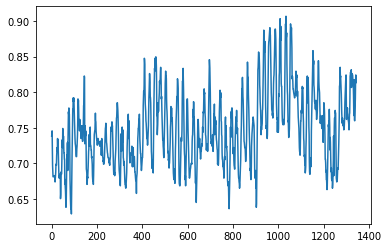

In [56]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

The following plot shows one of the output signals that we want to be able to predict given the 20 input signals. Note that the x axis represents the hours in the 8-day sequence. 

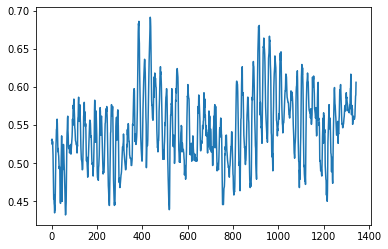

In [57]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

This neural network trains quickly and we can therefore train over many epochs.To avoid overfitting and therefore poor generalization of the model, we'll monitor the performance on the `test set` after each epoch and will only save the weights at each iteration if they're showing improved performance. 

Even though we're only using batches of data for the training, we'll validate on the entire sequence of test data. 

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

### Creating the RNN

In [0]:
model = Sequential()

**We can now add a Gated Recurrent Unit (GRU) to the network. This will have 512 outputs for each time-step in the sequence. Also, each observation will have `num_x_signals=20`**



The keyword `None` below states that the length of the batch of sequences will be arbitrary 

In [0]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

The GRU outputs a batch of sequences of 512 values but we only want to predict 3 output signals, so we add a fully-connected (or dense) layer that maps those 512 values down to only 3. 

In [0]:
model.add(Dense(num_y_signals, activation='sigmoid'))


In [0]:

if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### **Loss function**

We'll give the loss function 50 warmup steps so that we ignore the first values during training and won't count them towards our measurement of accuracy since the system isn't stable at the beginning. 

In [0]:
warmup_steps = 50


In [0]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

In [0]:
optimizer = RMSprop(lr=1e-3)


In [0]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)


In [67]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         820224    
_________________________________________________________________
dense (Dense)                (None, None, 3)           1539      
Total params: 821,763
Trainable params: 821,763
Non-trainable params: 0
_________________________________________________________________


### Callback functions 
The following cell creates a ModelCheckpoint object so that we can save checkpoints and log the progress to TensorBoard to be able to create the appropriate callbacks to Keras as needed. 

In [0]:

path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

### Early stopping
If the performance starts to worsen on the validation set, then stop the optimization of the model after 5 epochs of no improvement, as determined by `patience = 5`. 

In [0]:

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

### Calling back TensorBoard log during training

In [0]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

If the validation loss has not improved since the last epoch (as indicate by `patience = 0`), the learning rate will drop to `min_lr` which is `1e-4` in this case. 

In [0]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [0]:

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [73]:

%%time
model.fit(x=generator,
          epochs=1,
          steps_per_epoch=100,
          validation_data=validation_data,
          callbacks=callbacks)

100/100 [==============================] - ETA: 0s - loss: 0.0085
Epoch 00001: val_loss improved from inf to 0.00418, saving model to 23_checkpoint.keras
100/100 [==============================] - 76s 757ms/step - loss: 0.0085 - val_loss: 0.0042 - lr: 0.0010
CPU times: user 58.2 s, sys: 25 s, total: 1min 23s
Wall time: 1min 24s


### Load checkpoint
Keeping the best performance on the test-set reloading to the last saved checkpoint. 

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)


### Performance on test-set
We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.



In [75]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 1ms/step - loss: 0.0042


In [76]:
print("loss (test-set):", result)


loss (test-set): 0.004179853480309248


In [0]:

# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))


### Generate Predictions
This helper-function plots the predicted and true output-signals.

In [0]:
def plot_comparison(start_idx, length=100, train=True):

    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

These plots only show the output-signals and not the 20 input-signals used to predict the output-signals. The time-shift between the input-signals and the output-signals is held fixed in these plots. The model always predicts the output-signals e.g. 24 hours into the future (as defined in the shift_steps variable above). So the plot's x-axis merely shows how many time-steps of the input-signals have been seen by the predictive model so far.

* Notice that the model is not very accurate for the first time steps because it knows very little of the history of the input-signals and cannot make an accurate prediction. 
* We leave 30-50 time steps for the model to warm up and stabilize. This time interval is shown by the grey window below. These 50 time steps will be ignored when we calculate the mean-squared error. 

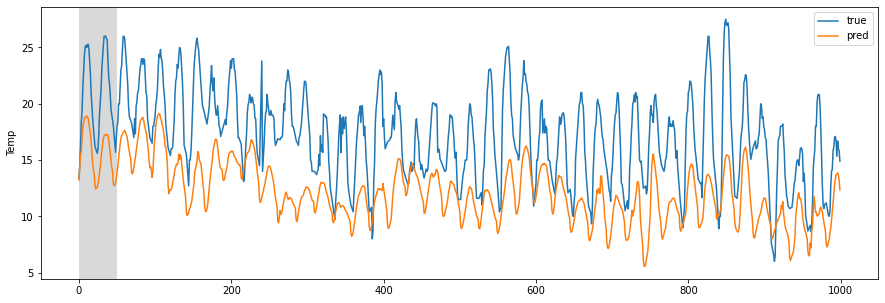

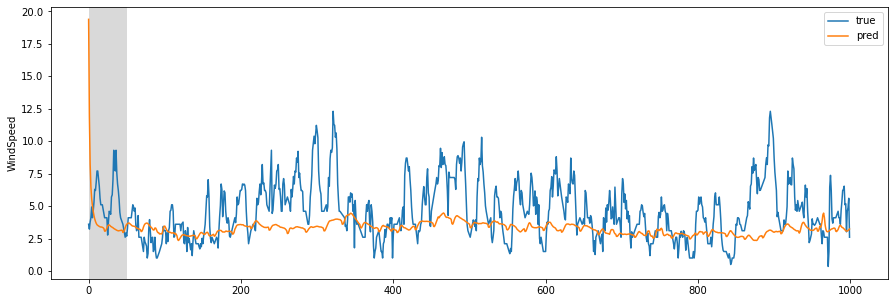

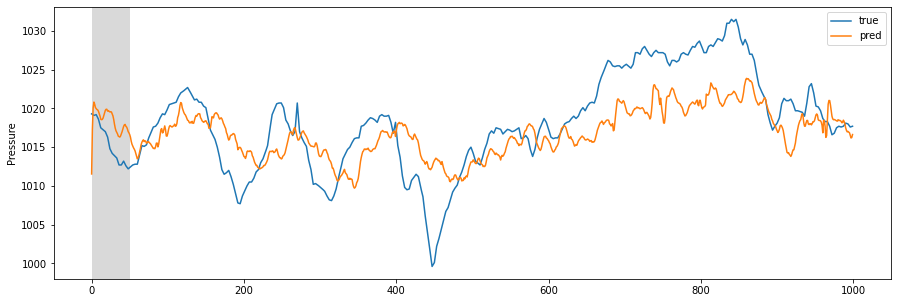

In [82]:
plot_comparison(start_idx=100000, length=1000, train=True)


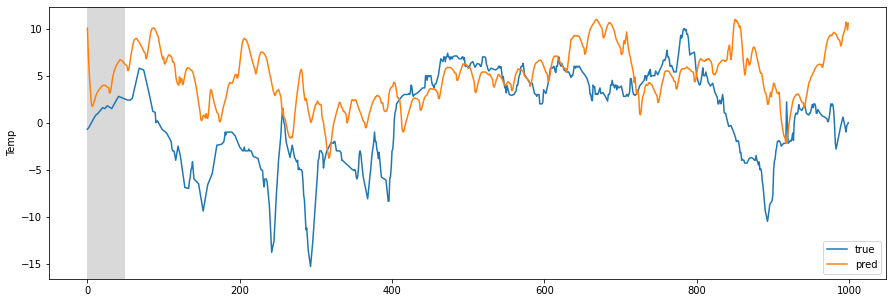

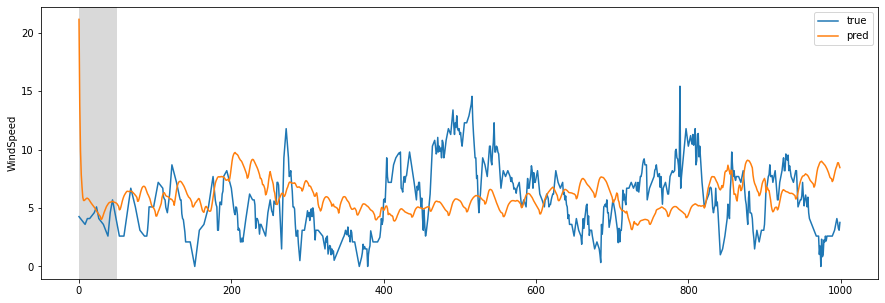

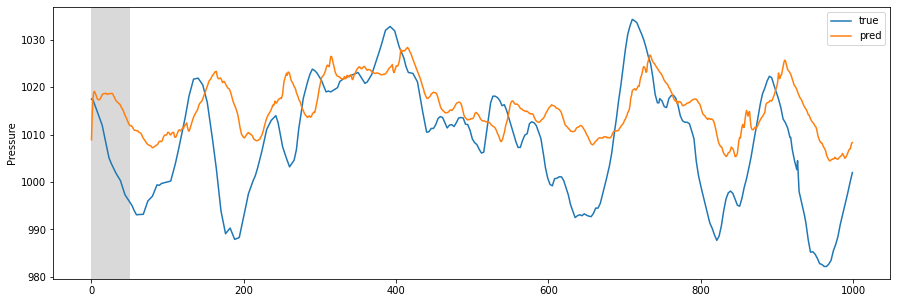

In [83]:
plot_comparison(start_idx=200000, length=1000, train=True)


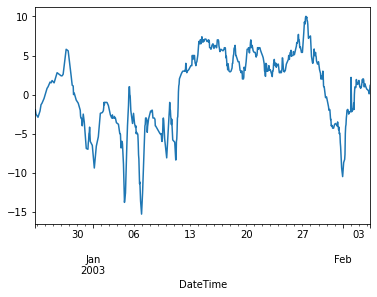

In [84]:
df['Odense']['Temp'][200000:200000+1000].plot();


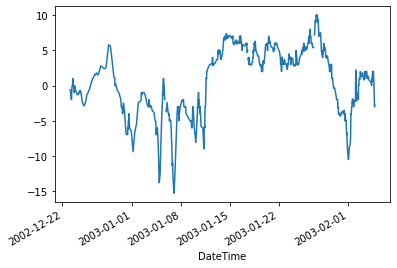

In [85]:

df_org = weather.load_original_data()
df_org.xs('Odense')['Temp']['2002-12-23':'2003-02-04'].plot();

### Example from Test-Set
Now we'll see the model's performance on data it has not seen before 

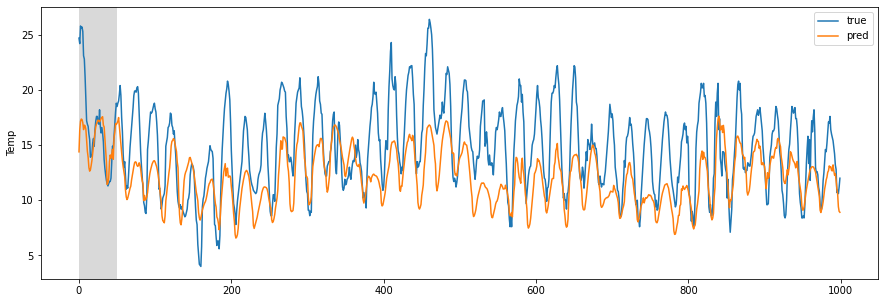

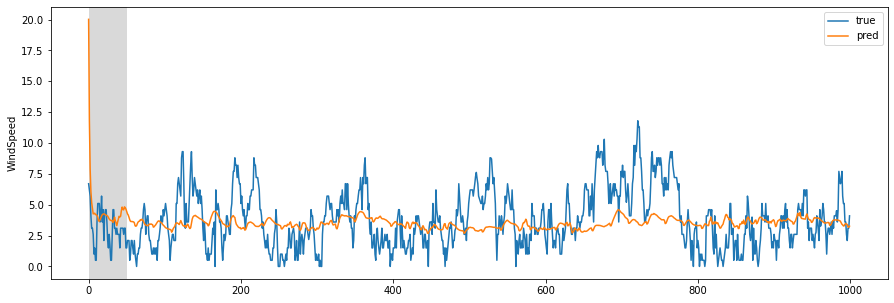

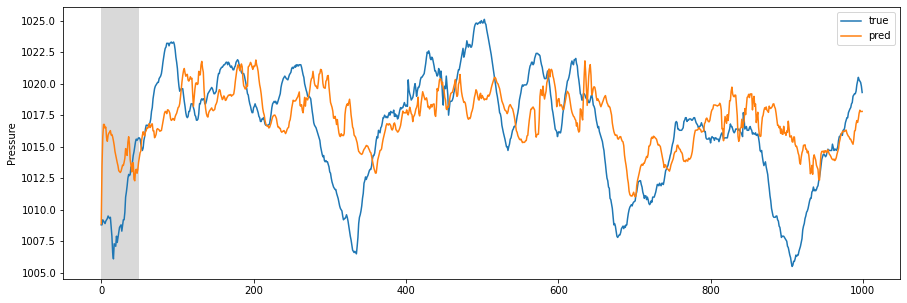

In [86]:
plot_comparison(start_idx=200, length=1000, train=False)
